### Imports

In [1]:
import numpy as np
from scipy.io import loadmat
from ternary.helpers import project_sequence

import tensorflow as tf

from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import ternary

from sklearn.manifold import spectral_embedding
from sklearn.mixture import GaussianMixture

import gpflow

from scipy.stats import entropy

### Load in the relevant data

In [2]:
# read the data from the control (fully autonomous) run
auto_order = np.loadtxt(fname='autonomous_predicted_labels.txt',
                        skiprows=1,
                        max_rows=1,
                        dtype=int)

auto_label = np.loadtxt(fname='autonomous_predicted_labels.txt',
                        skiprows=3)

# read the data from the run of interest
time_string = '2022-06-16-09-37'

test_order = np.loadtxt(fname=f'labels/predicted_labels_{time_string}.txt',
                        skiprows=1,
                        max_rows=1,
                        dtype=int)

test_label = np.loadtxt(fname=f'labels/predicted_labels_{time_string}.txt',
                        skiprows=3)

# import the experimental data, including the...
experimental_data = loadmat('FeGaPd_full_data_220104a.mat')

# ..."true" labels from the data set, ...
true_label = experimental_data['labels_col'][0][1].flatten()

# ...composition data in cartesian coordinates, ...
composition = experimental_data['C']
idx = [1, 2, 0]
cartesian = np.array(list(zip(*project_sequence(composition[:, idx]))))

# ...and x ray diffraction data
xrd = experimental_data['X'][:, 631:1181]

### Set the random seeds

In [3]:
# seed the numpy and tensorflow random number generation for reproducability
seed = 1
rng = np.random.RandomState(seed)
tf.random.set_seed(seed)

### Indicate which experiment iteration to simulate

In [4]:
measured = auto_order[:30]

### Calculate the clutering similarity matrix

In [5]:
sc_lengthscale = 0.7
# calculate the similarity matrix
pairwise_distance = squareform(pdist(xrd[measured, :], 'cosine'))
similarity_matrix = np.exp(-(pairwise_distance**2) / (2 * sc_lengthscale**2))

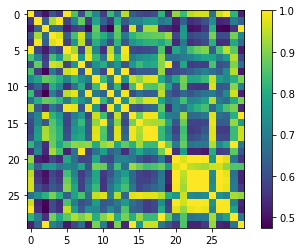

In [6]:
# display the similarity matrix
fig, ax = plt.subplots()
image = ax.imshow(similarity_matrix)
fig.colorbar(image)

plt.show()

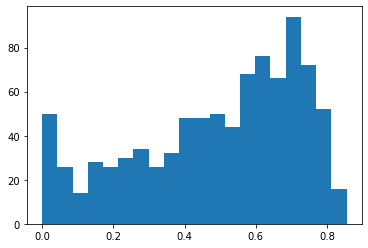

In [7]:
# histogram of similarities
fig, ax = plt.subplots()
ax.hist(pairwise_distance.flatten(), bins=20)

plt.show()

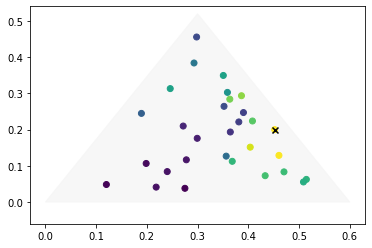

In [8]:
# plot the measured points colored based on their similarity to specified point
comparison_index = 10

fig, tax = ternary.figure(scale=0.6)

# the measured points
tax.get_axes().scatter(cartesian[measured, 0],
                       cartesian[measured, 1],
                       c=similarity_matrix[:, comparison_index])
                       
# the comparison point in black
tax.get_axes().scatter(cartesian[measured[comparison_index], 0],
                       cartesian[measured[comparison_index], 1],
                       marker='x',
                       c=[[0, 0, 0]])

plt.show()

### Perform the "ground truth" spectral clustering

In [9]:
num_clusters = 5

spectral_clusters = spectral_embedding(adjacency=similarity_matrix,
                                       n_components=num_clusters,
                                       random_state=rng)


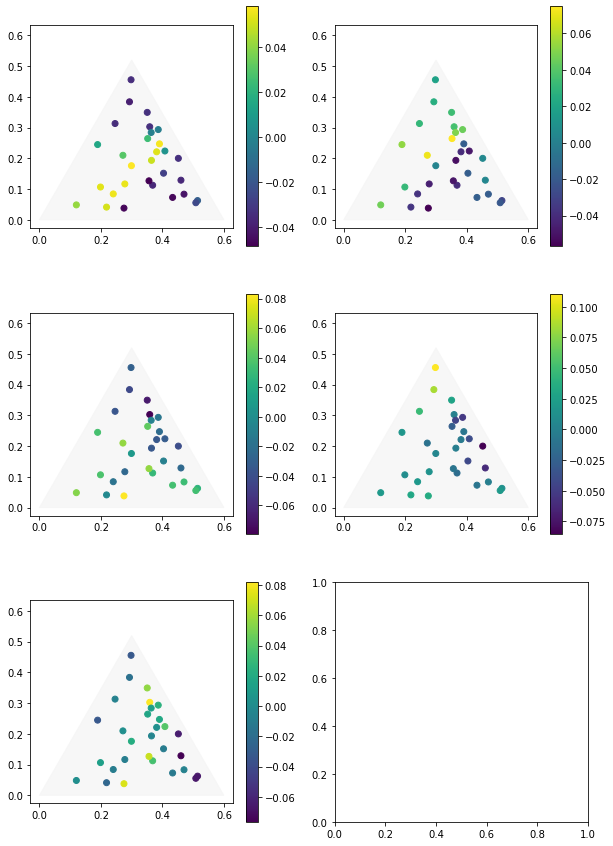

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(num_clusters):
    tax = ternary.TernaryAxesSubplot(ax=ax.flatten()[i], scale=0.6)

    # the measured points
    p = tax.get_axes().scatter(cartesian[measured, 0],
                               cartesian[measured, 1],
                               c=spectral_clusters[:, i])

    plt.colorbar(p, ax=ax.flatten()[i])

    tax.get_axes().axis('square')

plt.show()


In [11]:
mixture_model = GaussianMixture(n_components=num_clusters,
                                covariance_type='diag',
                                n_init=10,
                                random_state=rng).fit(spectral_clusters)

cluster_probabilities = mixture_model.predict_proba(spectral_clusters)


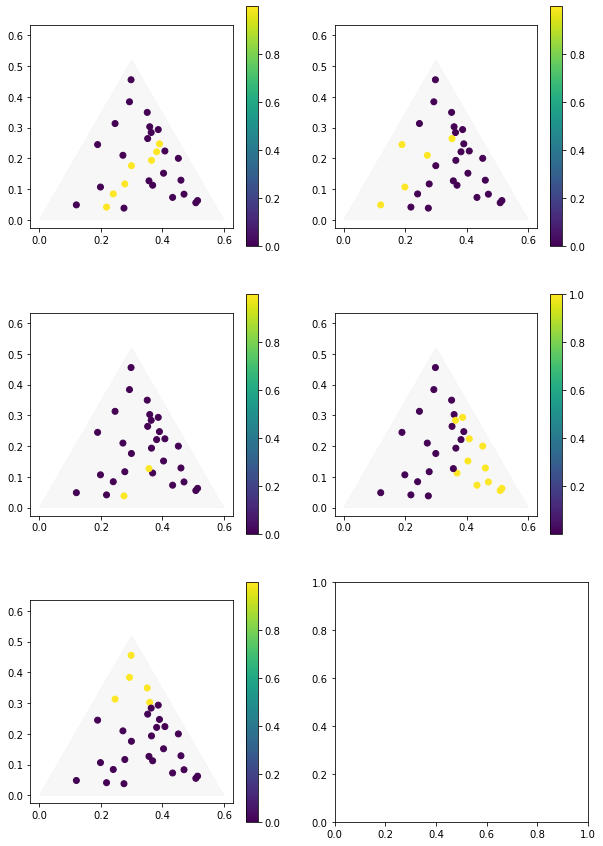

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(num_clusters):
    tax = ternary.TernaryAxesSubplot(ax=ax.flatten()[i], scale=0.6)

    # the measured points
    p = tax.get_axes().scatter(cartesian[measured, 0],
                               cartesian[measured, 1],
                               c=cluster_probabilities[:, i])

    plt.colorbar(p, ax=ax.flatten()[i])

    tax.get_axes().axis('square')

plt.show()


### Train the Gaussian Process Classifier on the Spectral Clustering

In [85]:
labels = np.argmax(cluster_probabilities, axis=1).flatten()

data = (cartesian[measured, :], labels)

kernel = gpflow.kernels.Matern32(lengthscales=[1, 1])

# gpflow.utilities.set_trainable(kernel.variance, False)

invlink = gpflow.likelihoods.RobustMax(num_clusters)

gpflow.utilities.set_trainable(invlink.epsilon, True)

likelihood = gpflow.likelihoods.MultiClass(num_clusters, invlink=invlink)

gp_model = gpflow.models.VGP(data=data,
                             kernel=kernel,
                             likelihood=likelihood,
                             num_latent_gps=num_clusters)

opt = gpflow.optimizers.Scipy()
opt_result = opt.minimize(gp_model.training_loss,
                          gp_model.trainable_variables,
                          options={'maxiter': 1000})

print(opt_result)
gp_model


      fun: 47.2219727541231
 hess_inv: <2479x2479 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.15697106e-05, -1.30702880e-04, -6.76921324e-05, ...,
        2.32496585e-04, -8.24753638e-07, -4.48501815e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 65
     njev: 72
   status: 0
  success: True
        x: array([ 1.02774953,  0.16773059, -0.75745362, ..., -1.64032271,
        0.54138946, -1.13910778])


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.000040836520964
VGP.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.13743845 0.17723988]
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,True,(),float64,0.242484210914539
VGP.num_data,Parameter,Identity,,False,(),int32,30
VGP.q_mu,Parameter,Identity,,True,"(30, 5)",float64,"[[1.02774953e+00, 1.67730590e-01, -7.57453618e-01..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(5, 30, 30)",float64,"[[[4.16678175e-01, 0.00000000e+00, 0.00000000e+00..."


In [86]:
y_mean, y_variance = tuple(t.numpy() for t in gp_model.predict_y(cartesian))
f_mean, f_variance = tuple(t.numpy() for t in gp_model.predict_f(cartesian))

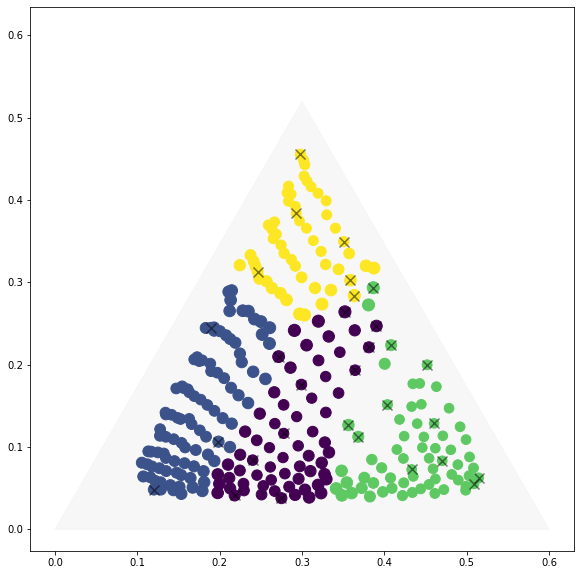

In [87]:
gp_labels = np.argmax(y_mean, axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
tax = ternary.TernaryAxesSubplot(ax, scale=0.6)

label_entropy = [entropy(l) for l in y_mean]

tax.get_axes().scatter(cartesian[:, 0],
                       cartesian[:, 1],
                       c=gp_labels,
                       s=[100 * e for e in label_entropy])

tax.get_axes().scatter(cartesian[measured, 0],
                       cartesian[measured, 1],
                       color=[0, 0, 0, 0.5],
                       marker='x',
                       s=100)                     

tax.get_axes().axis('square')

plt.show()

### Train the Gaussian Process Classifier on the Spectral Clustering and Human Input

In [88]:
# human input points
points = [(0.2, 0.3), (0.4, 0.3)]

x1, y1 = points[0]
x2, y2 = points[1]

# calculate the distance between each point the line
boundary_distance = [(x-x1)*(y2-y1)-(y-y1)*(x2-x1) for (x, y) in cartesian]

user_labels = [1 if d > 0 else 0 for d in boundary_distance]

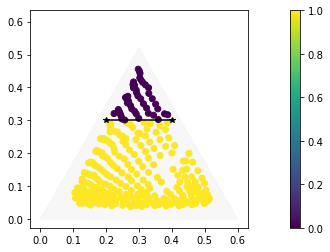

In [89]:
fig, tax = ternary.figure(scale=0.6)

# plot user points
x, y = zip(*points)

tax.get_axes().plot(x, y, 'k*-')

# plot samples, colored by user labels
p = tax.get_axes().scatter(cartesian[:, 0],
                           cartesian[:, 1],
                           c=user_labels)

plt.colorbar(p)

tax.get_axes().axis('square')

plt.show()


In [90]:
# kernel for user input
user_kernel = gpflow.kernels.SquaredExponential(active_dims=[2],
                                                lengthscales=0.001,
                                                variance=1)

# fix the prior kernel lengthscale and variance
gpflow.utilities.set_trainable(user_kernel.lengthscales, False)
# gpflow.utilities.set_trainable(user_kernel.variance, False)

# add prior kernel to clustering kernel
composition_kernel = gpflow.kernels.Matern32(active_dims=[0, 1],
                                             lengthscales=[1, 1])

# fix the composition kernel variance
# gpflow.utilities.set_trainable(composition_kernel.variance, False)

# combine the two kernels
hitl_kernel = composition_kernel + user_kernel

# organize hitl input data
hitl_data = np.column_stack((cartesian, user_labels))

hitl_input = (hitl_data[measured, :], labels)

invlink = gpflow.likelihoods.RobustMax(num_clusters)

gpflow.utilities.set_trainable(invlink.epsilon, True)

likelihood = gpflow.likelihoods.MultiClass(num_clusters, invlink=invlink)

hitl_gp_model = gpflow.models.VGP(data=hitl_input,
                                  kernel=hitl_kernel,
                                  likelihood=likelihood,
                                  num_latent_gps=num_clusters)

opt = gpflow.optimizers.Scipy()
opt_result = opt.minimize(hitl_gp_model.training_loss,
                          hitl_gp_model.trainable_variables,
                          options={'maxiter': 1000})

print(opt_result)
hitl_gp_model


      fun: 44.53572966692902
 hess_inv: <2480x2480 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.21995620e-04,  4.67960341e-04,  2.87536636e-05, ...,
        8.15250111e-05, -8.36973180e-05,  9.70260547e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 146
      nit: 130
     njev: 146
   status: 0
  success: True
        x: array([ 0.74303987,  0.17740612, -0.78403799, ...,  0.86146538,
        0.79200645, -1.15590504])


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.2139111012149173
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.15031966 0.40930755]
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.165592162692533
VGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,False,(),float64,0.0010000000000000002
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,True,(),float64,0.23941215621859122
VGP.num_data,Parameter,Identity,,False,(),int32,30
VGP.q_mu,Parameter,Identity,,True,"(30, 5)",float64,"[[7.43039870e-01, 1.77406121e-01, -7.84037992e-01..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(5, 30, 30)",float64,"[[[3.21494952e-01, 0.00000000e+00, 0.00000000e+00..."


In [99]:
# hitl_gp_model.kernel.kernels[1].variance.assign(0.5)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-0.43275212956718845>

In [100]:
hitl_y_mean, hitl_y_variance = tuple(
    t.numpy() for t in hitl_gp_model.predict_y(hitl_data))
hitl_f_mean, hitl_f_variance = tuple(
    t.numpy() for t in hitl_gp_model.predict_f(hitl_data))

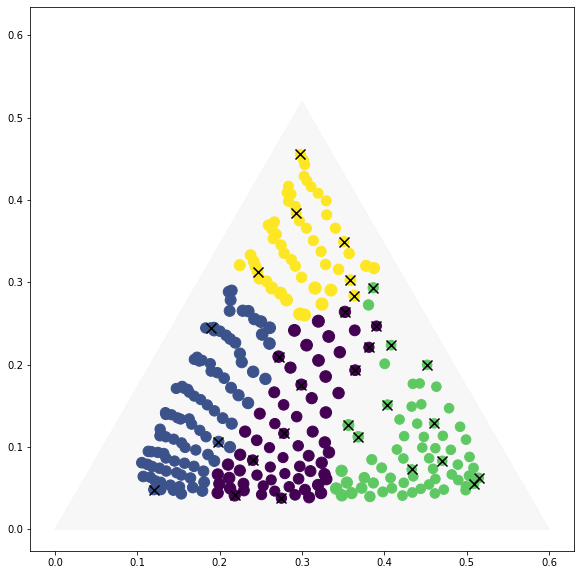

In [101]:
hitl_gp_labels = np.argmax(hitl_y_mean, axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
tax = ternary.TernaryAxesSubplot(ax, scale=0.6)

hitl_label_entropy = [entropy(l) for l in hitl_y_mean]

tax.get_axes().scatter(cartesian[:, 0],
                       cartesian[:, 1],
                       c=gp_labels,
                       s=[100 * e for e in hitl_label_entropy])

tax.get_axes().scatter(cartesian[measured, 0],
                       cartesian[measured, 1],
                       color=[0, 0, 0],
                       marker='x',
                       s=100)                     

tax.get_axes().axis('square')

plt.show()

### Compare Classification Confidence

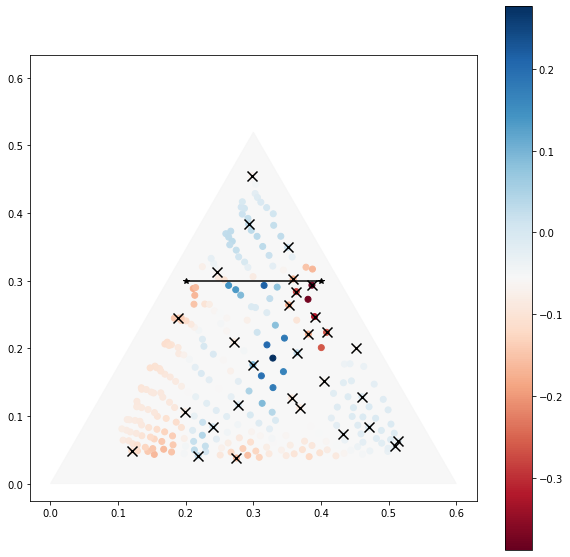

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))
tax = ternary.TernaryAxesSubplot(ax, scale=0.6)

tax.get_axes().plot(x, y, 'k*-')

entropy_change = np.array(hitl_label_entropy) - np.array(label_entropy)

p = tax.get_axes().scatter(cartesian[:, 0],
                           cartesian[:, 1],
                           c=entropy_change,
                           cmap='RdBu')

plt.colorbar(p)

tax.get_axes().scatter(cartesian[measured, 0],
                       cartesian[measured, 1],
                       color=[0, 0, 0],
                       marker='x',
                       s=100)

tax.get_axes().axis('square')

plt.show()
